In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import random

#tf.enable_eager_execution()

In [2]:
#data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                  fname='flower_photos', untar=True)
data_dir = pathlib.Path('/home/esdl/.keras/datasets/flower_photos')

label_names={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
label_key=['daisy','dandelion','roses','sunflowers','tulips']

In [3]:
all_images = list(data_dir.glob('*/*'))
all_images = [str(path) for path in all_images]
random.shuffle(all_images)
 
all_labels=[label_names[pathlib.Path(path).parent.name] for path in all_images]
data_size=len(all_images)

train_test_split=(int)(data_size*0.2)

x_train=all_images[train_test_split:]
x_test=all_images[:train_test_split]

y_train=all_labels[train_test_split:]
y_test=all_labels[:train_test_split]

IMG_SIZE=160

BATCH_SIZE = 32

def _parse_data(x,y):
    image = tf.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    #image = (image/127.5) - 1 # -1 ~ 1
    image = (image/255.0) # 0 ~ 1
    image = tf.image.resize_images(image, (IMG_SIZE, IMG_SIZE))
    
    return image,y

def _input_fn(x,y):
    ds=tf.data.Dataset.from_tensor_slices((x,y))
    ds=ds.map(_parse_data)
    ds=ds.shuffle(buffer_size=data_size)
    
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=1)
    return ds
  
train_ds=_input_fn(x_train,y_train)
validation_ds=_input_fn(x_test,y_test)

In [4]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
bloc

In [5]:
model = tf.keras.Sequential()

for layer in vgg_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(len(label_names), activation='softmax'))

In [6]:
# Override
#last = vgg_model.outputs[0]
vgg_model.trainable=False
x = vgg_model.layers[-6].output
x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
preds = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)

In [6]:
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=preds)

NameError: name 'preds' is not defined

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [ ]:
vgg_model.trainable=False

In [ ]:
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

model = tf.keras.Sequential([
    vgg_model,
    #tf.keras.layers.ZeroPadding2D(padding=(1, 1)),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names), activation='softmax')
    #global_average_layer,
    #prediction_layer
])

# 왜 인지 모르겠지만 sequential 로 하면 vgg 모델과 sequential 모델이 겹친다고???
# 출처 : https://stackoverflow.com/questions/55466320/grad-cam-visualization-invalid-argument-error-you-must-feed-a-value-for-placeh

In [7]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [8]:
history = model.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=validation_ds)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2/2 [==============================] - 16s 8s/step - loss: 2.9555 - acc: 0.2344 - val_loss: 2.1666 - val_acc: 0.2812
Epoch 2/100
2/2 [==============================] - 0s 113ms/step - loss: 2.0053 - acc: 0.2656 - val_loss: 1.4816 - val_acc: 0.4531
Epoch 3/100
2/2 [==============================] - 0s 80ms/step - loss: 1.7315 - acc: 0.2812 - val_loss: 1.8452 - val_acc: 0.2969
Epoch 4/100
2/2 [==============================] - 0s 74ms/step - loss: 1.6912 - acc: 0.2656 - val_loss: 1.2454 - val_acc: 0.4844
Epoch 5/100
2/2 [==============================] - 0s 86ms/step - loss: 1.2583 - acc: 0.4688 - val_loss: 1.0836 - val_acc: 0.6719
Epoch 6/100
2/2 [==============================] - 0s 99ms/step - loss: 1.1331 - acc: 0.5625 - val_loss: 1.2698 - val_acc: 0.4688
Epoch 7/100
2/2 [==============================] - 0s 103ms/step - loss: 1.1505 - acc: 0.4688 - val_loss: 1.0100 - val_acc: 0.5469
Epoch 8/100
2/2 [========================

In [9]:
validation_steps = 20
 
loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)
 
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 8s 393ms/step - loss: 0.5401 - acc: 0.8047
loss: 0.54
accuracy: 0.80


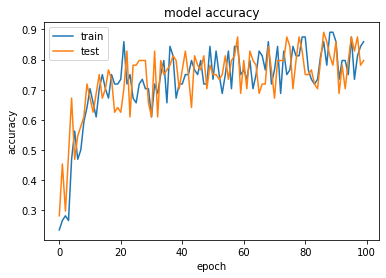

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

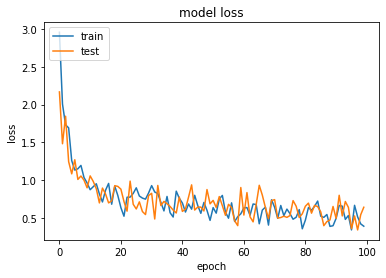

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

roses


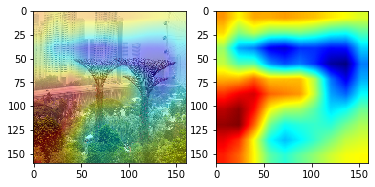

In [12]:
from PIL import Image

what = 20

img = Image.open(x_test[what]).resize((160, 160))
img_arr = np.asarray(img)[:, :, :3] / 255
img_array = np.expand_dims(img_arr, 0)


get_output = tf.keras.backend.function([model.layers[0].input],[model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img_array])
conv_outputs = conv_outputs[0, :, :, :]
class_weights = model.layers[-1].get_weights()[0]
cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, y_test[what]]):
    cam += w * conv_outputs[:, :, i]
cam = (cam - np.min(cam))/(np.max(cam)-np.min(cam))
cam = np.uint8(255 * cam)
cam = np.expand_dims(cam, axis=2)

cam = cv2.applyColorMap(cv2.resize(cam, (160, 160)), cv2.COLORMAP_JET)
# cv2 는 bgr 이므로 바꿔~!
cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

temp = cam
result = np.asarray(img) * 0.5 + cam * 0.3
result -= np.min(result)
result /= np.max(result)

plt.subplot(1,2,1)
#plt.imshow(img_arr)
#plt.subplot(1,2,2)
#plt.imshow(cam)

plt.imshow(result)
print(label_key[np.argmax(predictions)])

plt.subplot(1,2,2)
plt.imshow(temp)

In [22]:
conv_outputs[:].shape

(10, 10, 1024)

In [28]:
conv_outputs[:,:,1]

array([[0.        , 0.        , 0.23734596, 0.35730135, 0.1824791 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.32853314, 0.78716284, 0.9139242 , 0.5649874 ,
        0.        , 0.        , 0.        , 0.11208041, 0.        ],
       [0.        , 0.19591418, 0.7016165 , 0.8869792 , 0.48426822,
        0.        , 0.        , 0.        , 0.04236883, 0.        ],
       [0.        , 0.        , 0.490449  , 0.8092128 , 0.62033737,
        0.04012496, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.2664992 , 0.71019685, 0.7497998 ,
        0.26690093, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.2287856 , 0.73898417, 0.814099  ,
        0.29097497, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.21125808, 0.82772744, 0.9604702 ,
        0.3751548 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [34]:
np.transpose(np.reshape(conv_outputs,(10*10,1024))).shape

(1024, 100)

In [13]:
class_weights.shape

(1024, 5)

In [14]:
class_weights[:, y_test[what]].shape

(1024,)

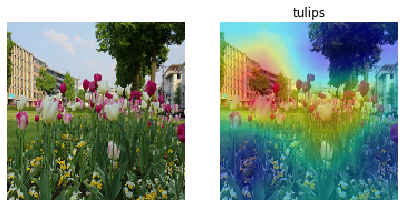

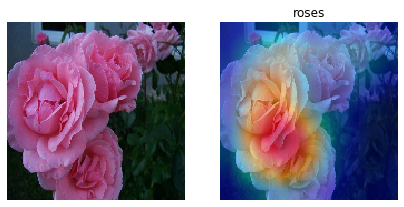

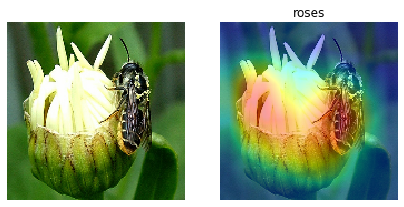

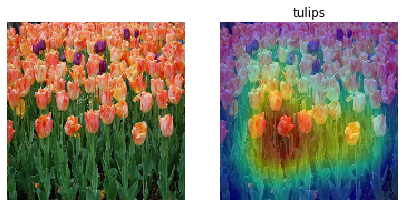

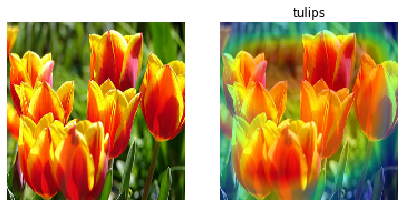

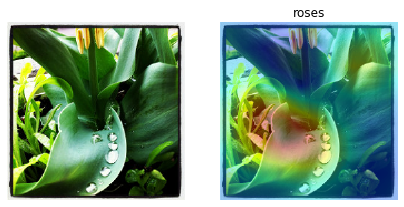

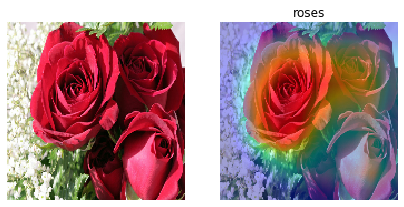

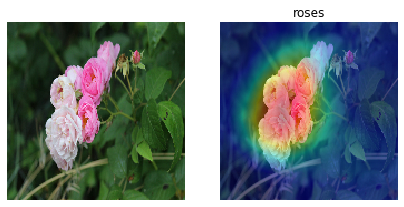

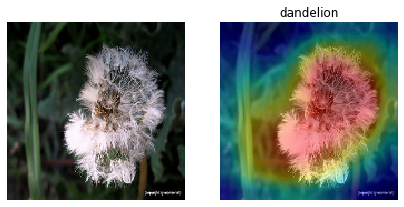

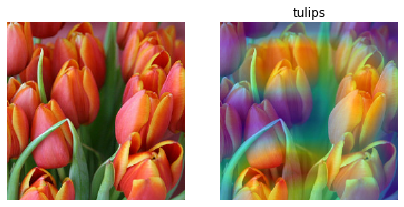

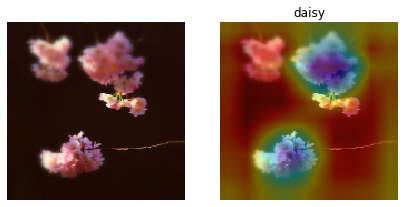

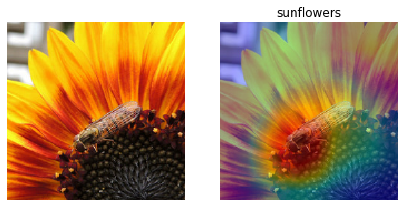

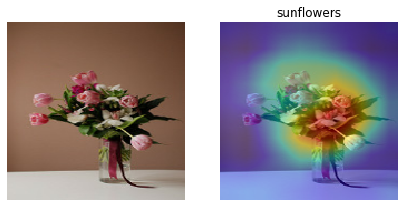

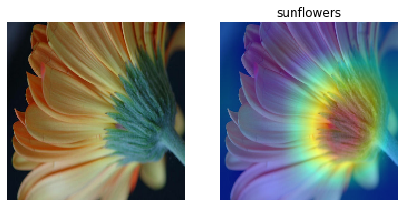

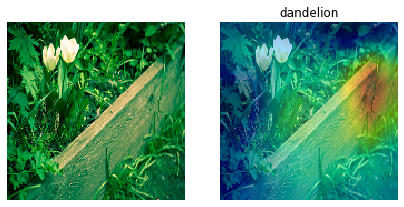

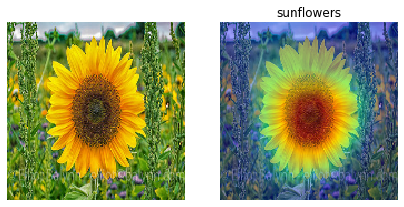

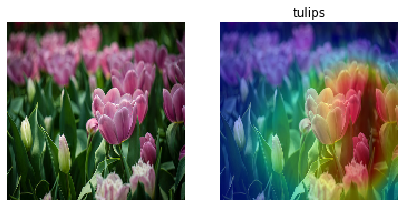

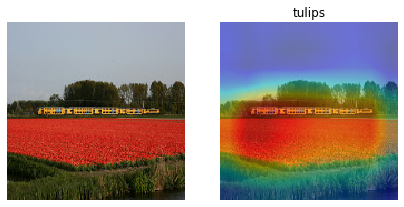

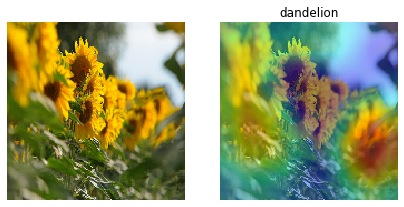

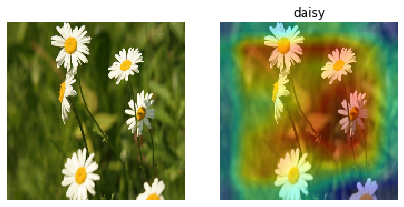

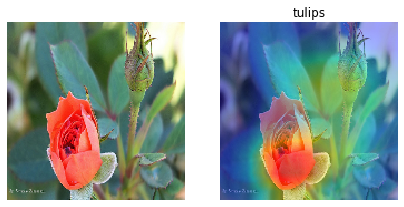

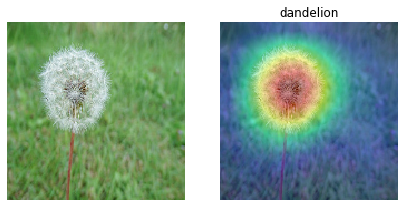

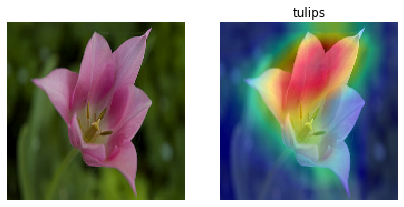

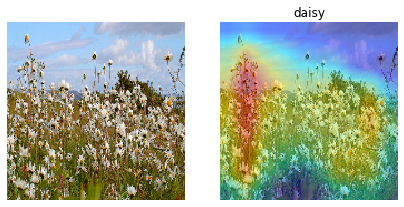

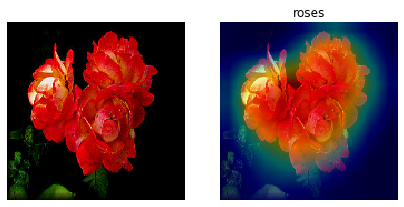

KeyboardInterrupt: 

In [17]:
iter = validation_ds.make_one_shot_iterator()
el = iter.get_next()
with tf.Session() as sess:
    data, label = sess.run(el)

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([data])
class_weights = model.layers[-1].get_weights()[0]

output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(10*10,1024))))
    cam = tf.keras.backend.eval(cam)
    cam = np.reshape(cam,(10,10))
    cam = (cam - np.min(cam))/(np.max(cam)-np.min(cam))
    cam = np.expand_dims(np.uint8(255 * cam), axis=2)
    cam = cv2.applyColorMap(cv2.resize(cam, (160, 160)), cv2.COLORMAP_JET)
    # cv2 는 bgr 이므로 바꿔~!
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    output.append(cam)

for idx, i in enumerate(output):
    image = np.asarray(data[idx]*255)
    result = image * 0.5 + i * 0.3
    result -= np.min(result)
    result /= np.max(result)
    plt.figure(figsize = (7,7))
    plt.subplot(1,2,1)
    plt.imshow(data[idx])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.axis('off')
    plt.title(label_key[np.argmax(predictions[idx])])
    plt.show()

# Another example

In [ ]:
vgg_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

In [ ]:
model = tf.keras.Sequential([
  vgg_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=validation_ds)

In [ ]:
validation_steps = 20
 
loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)
 
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
from PIL import Image

what = 2

img = Image.open(x_test[what]).resize((160, 160))
img_arr = np.asarray(img)[:, :, :3] / 255
img_array = np.expand_dims(img_arr, 0)


get_output = tf.keras.backend.function([model.layers[0].input],[model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([img_array])
conv_outputs = conv_outputs[0, :, :, :]
class_weights = model.layers[-1].get_weights()[0]
cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, y_test[what]]):
    cam += w * conv_outputs[:, :, i]
cam /= np.max(cam)
cam = cv2.resize(cam, (160, 160))

plt.subplot(1,2,1)
plt.imshow(img_arr)
plt.subplot(1,2,2)
plt.imshow(cam)